In [22]:
#!/usr/bin/python

import sys
import os

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pylab as plt 
import seaborn as sns 
sns.set()

from CoLoc_class import CoLoc, pseudocounts, make_mockdata

# <!-- collapse=True -->
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
sns.set() 
sns.set_style('white')


This notebook aims to compare the theoretical estmates computed in the CoLoc class with numerically sampled values, verify the accuracy of made approximation. We generate random samples for each metric, for which we subsequently compute the mean and standard deviation. This allows us to compare quality of the approximations made, keeping other choices in the estimation procedure fixed (e.g. the choice of prior). Hence for all choices in the estimation procedure, these values should align. 

We explore two datasets: mock data with a multinomial distribution (as assumed in estimation procedure), and the BLS occupations data. 

### Import data BLS occupations data 

In [24]:
#major occupation groups 
df = pd.read_csv('./BLS2016_clean.csv')

df = df.loc[df['OCC_GROUP']=='major']

df['OCC_TITLE'] = df['OCC_TITLE'].apply(lambda x: x[:-12])

#drop Farming and drop PR 
df = df[~df['OCC_CODE'].str.startswith('45')]
df = df[~df['AREA_NAME'].str.contains('PR')]

df = df.pivot(index = 'AREA_NAME', columns ='OCC_TITLE', values = 'TOT_EMP').fillna(0)

#sort occs by size 
sorted_occix = np.argsort(df.sum(0).values)

#sort MSA's by size 
sorted_MSAix = np.argsort(df.sum(1).values)

df = df.iloc[sorted_MSAix,sorted_occix]

major_df = df/10 #note that we divide by 10 the data, assuming it is generated per 10 

### fuctions for sampling and plotting  

In [25]:
def create_samples(Q, sample_size):

    qt = Q.qt 
    
    pci_samples = np.random.dirichlet(Q.qt.values.flatten(), size = sample_size).reshape(sample_size,Q.Nc,Q.Ni)
    pc_samples = np.random.dirichlet(Q.qc, sample_size) #s,i
    pi_samples = np.random.dirichlet(Q.qi, sample_size) #s,c
    pc_i_samples = np.array([np.random.dirichlet(qc_i, sample_size) for qc_i in Q.qt.T.values]).T.swapaxes(0,1) #s,c,i 
    pi_c_samples = np.array([np.random.dirichlet(qi_c, sample_size) for qi_c in Q.qt.values]).swapaxes(0,1) #s,c,i
    
    PMIpci_samples = np.log(pci_samples) - np.log(pi_samples[:,None,:]) - np.log(pc_samples[:,:,None])
    PMIpc_i_samples = np.log(pc_i_samples) - np.log(pc_samples[:,:,None])
    PMIpi_c_samples = np.log(pi_c_samples) - np.log(pi_samples[:,None,:])
    KLpc_i_samples = np.einsum('sci, sci -> si', pc_i_samples, PMIpc_i_samples)    
    KLpi_c_samples = np.einsum('sci, sci -> sc', pi_c_samples, PMIpi_c_samples)    
    MIpci_samples = np.einsum('sci,sci -> s', pci_samples, PMIpci_samples) 
      
    pij_samples = np.einsum('scj,sci->sij',pi_c_samples,pci_samples)
    pj_i_samples = np.einsum('scj,sci->sij',pi_c_samples,pc_i_samples)

    PMIpij_samples = np.log(pij_samples) - np.log(pi_samples[:,None,:]) - np.log(pi_samples[:,:,None])   #s,i,j
    PMIpj_i_samples = np.log(pj_i_samples) - np.log(pi_samples)[:,None,:]
    KLpj_i_samples = np.einsum('sij, sij -> si', pj_i_samples, PMIpj_i_samples)  #sc
    MIpij_samples = np.einsum('sij,sij -> s', pij_samples, PMIpij_samples)  #s 

    posterior_samples_loc = [pci_samples, PMIpci_samples, KLpc_i_samples, KLpi_c_samples, MIpci_samples]
    posterior_samples_coloc = [pij_samples, PMIpij_samples, pj_i_samples, KLpj_i_samples, MIpij_samples]
    
    return posterior_samples_loc, posterior_samples_coloc


def plot_loc_figs(Q, posterior_samples, title):
    
    posterior_expectation = [x.mean(axis = 0) for x in posterior_samples]
    posterior_std = [x.std(axis = 0) for x in posterior_samples]
    
    posterior_summary = list(zip(posterior_expectation, posterior_std))
    
    fig, ax = plt.subplots(2, 4, figsize=(16, 8))
    
    anal_vars = [(Q.pci, np.sqrt(Q.varpci)), 
                 (Q.make_PMIpci(), Q.make_stdPMIpci()), 
                 (Q.make_KLpc_i(), Q.make_stdKLpc_i()),
                 (Q.make_KLpi_c(), Q.make_stdKLpi_c())]

    
    subtitles = [('$p_{ci}$','standard deviation $p_{ci}$'),
                 ('$PMI(p_{ci})$','standard deviation $PMI(p_{ci})$'),
                 ('$KL(p_{c|i})$','standard deviation $KL(p_{c|i})$'),
                 ('$KL(p_{i|c})$','standard deviation $KL(p_{i|c})$')]
     
    
    for i in range(4):

        ax[0,i].plot(posterior_summary[i][0].flatten(), anal_vars[i][0].values.flatten(), '.')
        ax[1,i].plot(posterior_summary[i][1].flatten(), anal_vars[i][1].values.flatten(), '.')

        ax[0,i].set_title(subtitles[i][0])
        ax[1,i].set_title(subtitles[i][1])
        ax[1,i].set_xlabel('sampled values')


    ax[0,0].set_ylabel('analytical approximation')
    ax[1,0].set_ylabel('analytical approximation')



    for x in ax.flatten():

        x.axis('equal')
        x.set_ylim(x.get_xlim())
        x.set_yticks(x.get_xticks())
        x.plot(x.get_xlim(),x.get_xlim(), alpha = .5)

        x.ticklabel_format(axis = 'both', style = 'scientific', scilimits = (0,0))



    fig.suptitle(title)    
    plt.tight_layout()


def plot_coloc_figs(Q, posterior_samples, title):
    
    posterior_expectation = [x.mean(axis = 0) for x in posterior_samples]
    posterior_std = [x.std(axis = 0) for x in posterior_samples]
    
    posterior_summary = list(zip(posterior_expectation, posterior_std))

    
    fig, ax = plt.subplots(2, 4, figsize=(16, 8))

    anal_vars = [(Q.pij, np.sqrt(Q.varpij)), 
                 (Q.make_PMIpij(), Q.make_stdPMIpij()),
                 (Q.pj_i, np.sqrt(Q.varpj_i)),
                 (Q.make_KLpj_i(), Q.make_stdKLpj_i())]


    subtitles = [('$p_{ij}$','standard deviation $p_{ij}$'),
                ('$PMI(p_{ij})$','standard deviation $PMI(p_{ij})$'),
                ('$p_{j|i}$','standard deviation $p_{j|i}$'),
                ('$KL(p_{j|i})$','standard deviation $KL(p_{j|i})$')]

    for i in range(4):

        ax[0,i].plot(posterior_summary[i][0].flatten(), anal_vars[i][0].values.flatten(), '.')
        ax[1,i].plot(posterior_summary[i][1].flatten(), anal_vars[i][1].values.flatten(), '.')

        ax[0,i].set_title(subtitles[i][0])
        ax[1,i].set_title(subtitles[i][1])
        ax[1,i].set_xlabel('sampled values')


    ax[0,0].set_ylabel('analytical approximation')
    ax[1,0].set_ylabel('analytical approximation')


    for x in ax.flatten():

        x.axis('equal')
        x.set_ylim(x.get_xlim())
        x.set_yticks(x.get_xticks())
        x.plot(x.get_xlim(),x.get_xlim(), alpha = .5)

        x.ticklabel_format(axis = 'both', style = 'scientific', scilimits = (0,0))


    fig.suptitle(title)
    plt.tight_layout()

## Comparison numerical samples vs analytical approximations for BLS major occupations 

In [41]:
perc = .05
nr_prior_obs = major_df.sum().sum()*perc / (1-perc) 

Q = CoLoc(major_df, prior = 'prop', nr_prior_obs = nr_prior_obs)
Q.make_colocprobs()

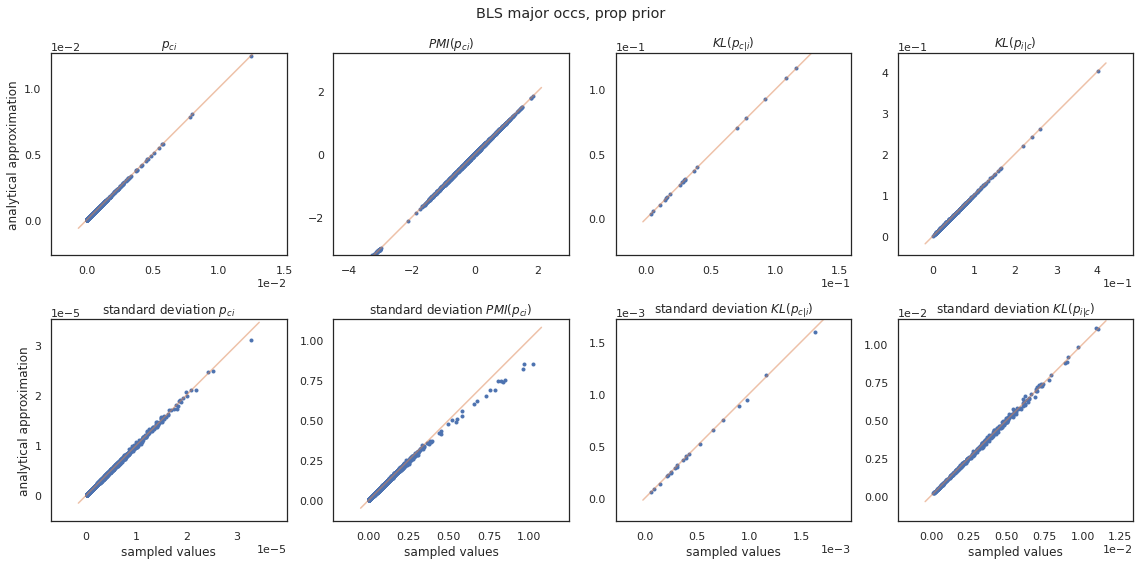

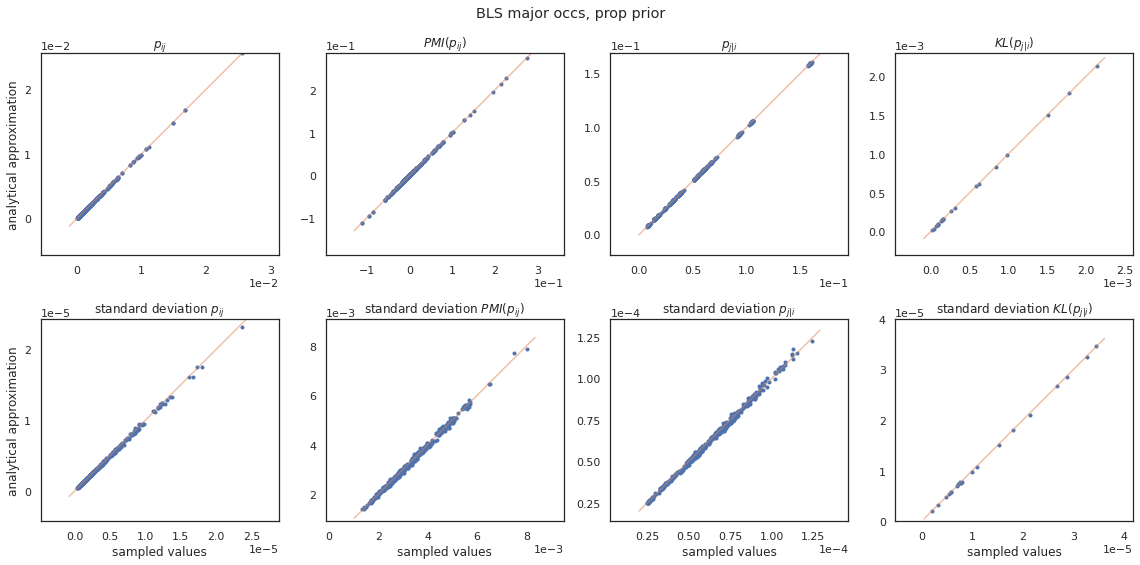

In [42]:
posterior_samples_loc, posterior_samples_coloc = create_samples(Q, 1000) 

plot_loc_figs(Q, posterior_samples_loc, 'BLS major occs, prop prior')

plt.savefig('./figures/numerical_BLS_loc.png', bbox_inches = 'tight', dpi=300)

plot_coloc_figs(Q, posterior_samples_coloc, 'BLS major occs, prop prior')

plt.savefig('./figures/numerical_BLS_coloc.png', bbox_inches = 'tight', dpi=300)

## Comparison numerical samples vs analytical approximations for multinomial mock data 

In [28]:
df = make_mockdata((10,10), n = 10000) 

Q = CoLoc(df, prior = None)
Q.make_colocprobs()

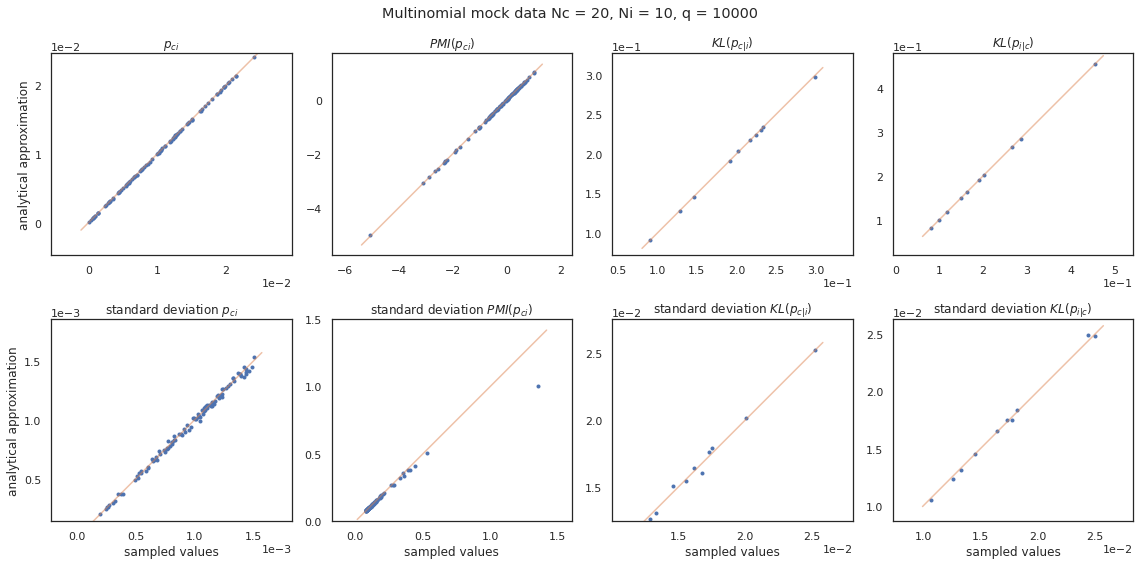

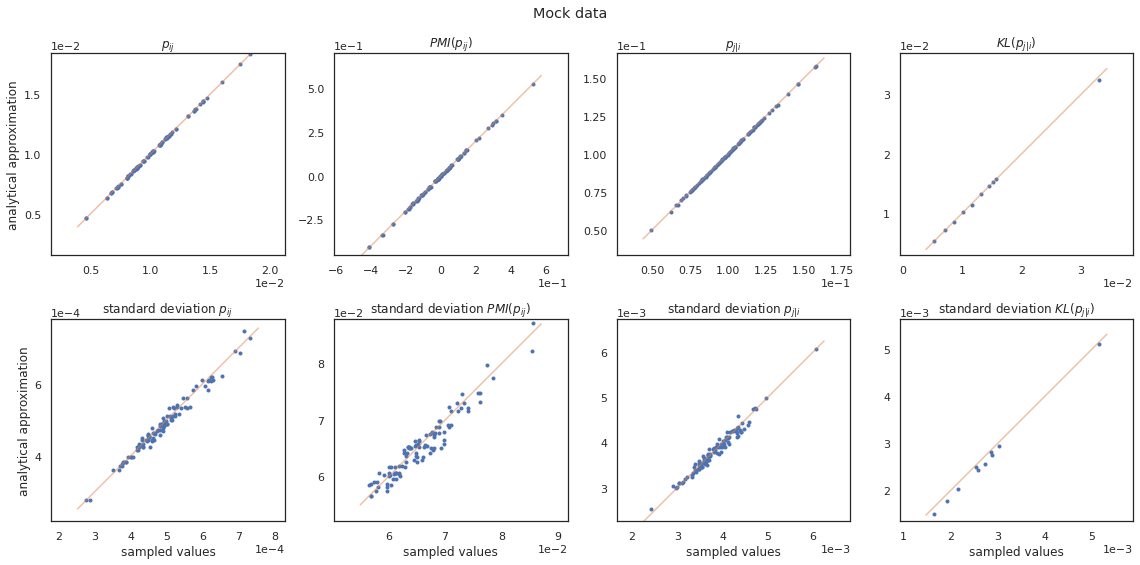

In [29]:
posterior_samples_loc, posterior_samples_coloc = create_samples(Q, 1000) 

plot_loc_figs(Q, posterior_samples_loc, 'Multinomial mock data Nc = 20, Ni = 10, q = 10000')

plt.savefig('./figures/numerical_mock_loc.png', bbox_inches = 'tight', dpi=300)

plot_coloc_figs(Q, posterior_samples_coloc, 'Mock data')

plt.savefig('./figures/numerical_mock_coloc.png', bbox_inches = 'tight', dpi=300)

## show normality of posteriors 

In [43]:
##take random samples from numerically sampled posteriors 

rng =  np.random.default_rng()

PMIci_posteriors = rng.choice(posterior_samples_loc[1].reshape(1000,-1), size = 8, axis = 1, replace = False)

ix = np.triu_indices_from(posterior_samples_coloc[1][0]) #plot upper triangular only
PMIij_posteriors = rng.choice(posterior_samples_coloc[1][:,ix[0],ix[1]], size = 8,axis = 1, replace = False)

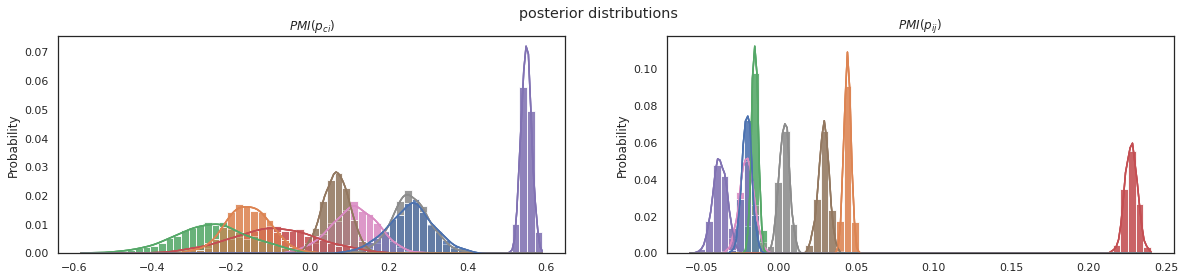

In [44]:
fig, ax = plt.subplots(ncols = 2, figsize=(20, 4))

for i in range(3):
    sns.histplot(PMIci_posteriors, ax = ax[0], stat = 'probability', kde = True, log_scale = False, legend = False, bins = 60)
    #sns.histplot(PMIci_posteriors_bot, ax = ax[1,0], stat = 'probability', kde = True, log_scale = False, legend = False)
    sns.histplot(PMIij_posteriors, ax = ax[1], stat = 'probability', kde = True, log_scale = False, legend = False, bins = 60)
    #sns.histplot(PMIij_posteriors_bot, ax = ax[1,1], stat = 'probability', kde = True, log_scale = False, legend = False)

ax[0].set_title(r'$PMI(p_{ci})$')
ax[1].set_title(r'$PMI(p_{ij})$')

    
fig.suptitle('posterior distributions') 

plt.savefig('./figures/posteriors.png', bbox_inches = 'tight', dpi=300)